**DATA PREPROCESSING** aka Data Loading

Reading into the Dataset and Table Docx

In [1]:
#importing libraries
import pandas as pd
from docx import Document

In [2]:
#specifying paths of different files
ds1='Datasets\\Survey_data_Inflight_Satisfaction_Score.csv'
ds2='Datasets\\Survey data _Customer comments.csv'
ds3='Datasets\\Inflight Service_Pre order data.csv'
ds4='Datasets\\Inflight Service_Inventory data.csv'

tb1='Table 1 - Inflight Satisfaction Score363691d.docx'
tb2='Table 2 - Customer comment-feedback Data.docx'
tb3='Table 3- Inflight service inventory data.docx'
tb4='Table 4 - Inflight preorder data.docx'

In [3]:
# Load the datasets
inventory_data = pd.read_csv(ds4)
pre_order_data = pd.read_csv(ds3)
customer_comments_data = pd.read_csv(ds2)
inflight_satisfaction_data = pd.read_csv(ds1)

inventory_data_head = inventory_data.head()
pre_order_data_head = pre_order_data.head()
customer_comments_data_head = customer_comments_data.head()
inflight_satisfaction_data_head = inflight_satisfaction_data.head()

inventory_data_head, pre_order_data_head, customer_comments_data_head, inflight_satisfaction_data_head

(   flight_number departure_station_code arrival_station_code  \
 0           2634                    IAX                  PDX   
 1           2666                    ORX                  IAX   
 2           2310                    DEX                  SAX   
 3           1712                    SFX                  CLX   
 4           1225                    LAX                  HNX   
 
   scheduled_departure_dtl  entree_product_id  \
 0                9/1/2022              58019   
 1                9/1/2022              60549   
 2                9/2/2022              58981   
 3                9/4/2022              58764   
 4                9/8/2022              60549   
 
                   entree_description entree_code  planned_entree_count  \
 0                     Belgium waffle          WF                    20   
 1  Vegetarian chili and polenta cake           V                     3   
 2                     Scrambled eggs           O                     9   
 3         M

In [5]:
# Function to read the .docx file and return the text
def read_docx(file_path):
    doc = Document(file_path)
    text = []
    for para in doc.paragraphs:
        text.append(para.text)
    return "\n".join(text)

# Read the column description documents
inflight_satisfaction_desc = read_docx(tb1)
customer_comments_desc = read_docx(tb2)
inventory_data_desc = read_docx(tb3)
pre_order_data_desc = read_docx(tb4)

# Show a snippet of each description to verify the content
inflight_satisfaction_desc[:300], customer_comments_desc[:300], inventory_data_desc[:300], pre_order_data_desc[:300]


('Table 1 - Inflight Satisfaction Score\nHighlighted rows together are primary key \n\n',
 'Table 2 - Customer comments/feedback\nHighlighted rows together are primary key \n\n',
 'Table 3 - Inflight Service: Inventory data (only for Business/First Class - J)\nHighlighted rows together are primary key \n\n\n',
 'Table 4 - Inflight Service: Pre order data (for All Cabins – J/Y)\nHighlighted rows together are primary key \n\n')

**DATA PREPROCESSING AND DATA CLEANING**

*Schema as stated through the Table Docx, we may perform **OUTER JOIN** as it is most suitable way to handle data  from all 4 datasets without any loss*

In [6]:
# Merge using OUTER JOIN on the primary keys
merged_data_1 = pd.merge(inventory_data, pre_order_data, 
                         on=['flight_number', 'scheduled_departure_dtl', 'departure_station_code', 'arrival_station_code'], 
                         how='outer')

merged_data_2 = pd.merge(merged_data_1, inflight_satisfaction_data, 
                         left_on=['flight_number', 'scheduled_departure_dtl', 'departure_station_code', 'arrival_station_code'], 
                         right_on=['flight_number', 'scheduled_departure_date', 'origin_station_code', 'destination_station_code'], 
                         how='outer')

final_merged_data = pd.merge(merged_data_2, customer_comments_data, 
                             left_on=['flight_number', 'scheduled_departure_dtl', 'departure_station_code', 'arrival_station_code'], 
                             right_on=['flight_number', 'scheduled_departure_date', 'origin_station_code', 'destination_station_code'], 
                             how='outer')

# Show the first few rows to verify if the data merging was successful
final_merged_data.head().shape

(5, 61)

In [7]:
final_merged_data.shape

(648742, 61)

In [31]:
final_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648742 entries, 0 to 648741
Data columns (total 62 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   flight_number                     648742 non-null  int64  
 1   departure_station_code            613969 non-null  object 
 2   arrival_station_code              613969 non-null  object 
 3   scheduled_departure_dtl           613969 non-null  object 
 4   entree_product_id                 492772 non-null  float64
 5   entree_description                492772 non-null  object 
 6   entree_code                       492772 non-null  object 
 7   planned_entree_count              492772 non-null  float64
 8   consumed_entree_count             492772 non-null  float64
 9   record_locator_x                  608591 non-null  object 
 10  carrier_code                      608591 non-null  object 
 11  cabin_code                        608591 non-null  o

**DESCRIPTIVE ANALYSIS**

Data Pre-Processing Steps involved: 
1. Conversion of string to int for score calculation.
2. Conversion of departure-arrival related columns to date-time format

In [8]:
final_merged_data['score'] = pd.to_numeric(final_merged_data['score'], errors='coerce')
satisfied_data = final_merged_data[(final_merged_data['score'] == 4) | (final_merged_data['score'] == 5)]
total_samples = final_merged_data['score'].count()
satisfied_samples = satisfied_data['score'].count()

inflight_satisfaction_rate = (satisfied_samples / total_samples) * 100

In [10]:
print('Satisfied sample post merge:', satisfied_samples, '\n total number of samples:', total_samples, '\n NPS:', inflight_satisfaction_rate)

Satisfied sample post merge: 91824 
 total number of samples: 233984 
 NPS: 39.24370897155361


With an **NPS (Net-Promoter Score) of approx 39.24% (close to 40%)**, it may be intercepted that there is ***significant room of improvement in F&B satisfaction***.

In [12]:
final_merged_data['consumption_rate'] = final_merged_data['consumed_entree_count'] / final_merged_data['planned_entree_count']
average_consumption_rate = final_merged_data['consumption_rate'].mean()
average_consumption_rate

inf

This shows some error in dataset as planned entree count might have been zero.

In [13]:
average_pre_order_qty = final_merged_data['pre_order_qty'].mean()
print('MEAN pre-order quantity',average_pre_order_qty)

MEAN pre-order quantity 1.210910118618251


With average pre-order quantity to be at 1.21, there is significant evidence that pre-orders are not significant amongst passengers.

**ROOT CAUSE ANALYSIS**

Methodologies to be taken in:

1. Correlation Matrix
2. Linear Regression
3. NLP based evaluation on customer feedback using NLTK

Pre-processing steps involved:
1. Indexing of string data-types
2. Removal of NULL values
3. One Hot Encoding

In [15]:
#correlation matrix
subset_columns = ['score', 'planned_entree_count', 'consumed_entree_count', 'pre_order_qty', 'arrival_delay_minutes']
correlation_matrix = final_merged_data[subset_columns].corr()
correlation_matrix

,score,planned_entree_count,consumed_entree_count,pre_order_qty,arrival_delay_minutes
score,1.000000,-0.018615,-0.018370,0.003422,-0.075713
planned_entree_count,-0.018615,1.000000,0.528054,-0.004296,0.039503
consumed_entree_count,-0.018370,0.528054,1.000000,-0.001465,0.007435
pre_order_qty,0.003422,-0.004296,-0.001465,1.000000,0.000187
arrival_delay_minutes,-0.075713,0.039503,0.007435,0.000187,1.000000


In [40]:
#Regression Analysis
# Perform a simple linear regression to identify key drivers of F&B satisfaction
# For the sake of this example, let's consider 'pre_order_qty', 'consumed_entree_count', and 'arrival_delay_minutes' as predictor variables
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Remove NaN values for the regression analysis
regression_data = final_merged_data[['score', 'pre_order_qty', 'consumed_entree_count', 'arrival_delay_minutes']].dropna()
X = regression_data[['pre_order_qty', 'consumed_entree_count', 'arrival_delay_minutes']]
y = regression_data['score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model and fit it to the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Get the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

correlation_matrix, coefficients, intercept


(                                                    Meal_Anthem Peppered Beef Jerky  \
 Meal_Anthem Peppered Beef Jerky                                            1.000000   
 Meal_Asian Vegetarian Meal                                                -0.004657   
 Meal_Bacardi Rum                                                          -0.005031   
 Meal_Baileys Irish Cream                                                  -0.006313   
 Meal_Belgium waffle                                                       -0.019955   
 ...                                                                             ...   
 Meal_White Claw Watermelon                                                -0.005380   
 Meal_White Wine                                                           -0.008313   
 Meal_Za'atar chicken with spinach, roasted pepp...                        -0.012122   
 Meal_Za’atar chicken                                                      -0.032183   
 Score                          

NameError: name 'satisfaction_data' is not defined

<Figure size 1200x800 with 0 Axes>

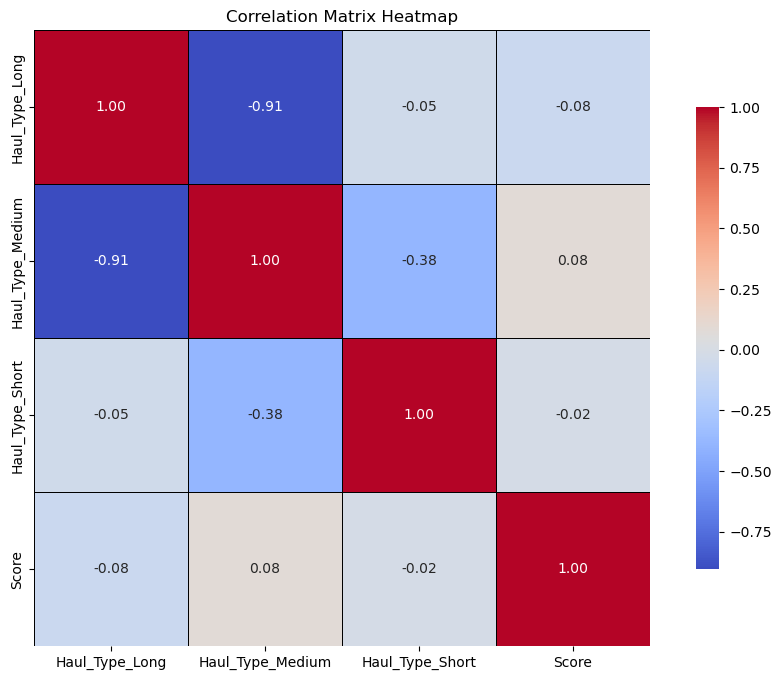

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=.5, linecolor='black', square=True,
            cbar_kws={"shrink": .75})
plt.title('Correlation Matrix Heatmap')
plt.show()


In [29]:
subset_data = final_merged_data.sample(frac=0.01, random_state=0)[['meal_short_description', 'score']].dropna()
one_hot_encoded_data = pd.get_dummies(subset_data['meal_short_description'], prefix='Meal')
one_hot_encoded_data['Score'] = subset_data['score']
correlation_matrix = one_hot_encoded_data.corr()
correlation_with_score = correlation_matrix.loc[:, ['Score']].sort_values(by='Score', ascending=False)

correlation_with_score.head()

,Score
Score,1.000000
Meal_Scrambled eggs,0.061376
Meal_Belgium waffle,0.056958
Meal_Jack Daniels,0.045496
Meal_Grilled chicken,0.038196


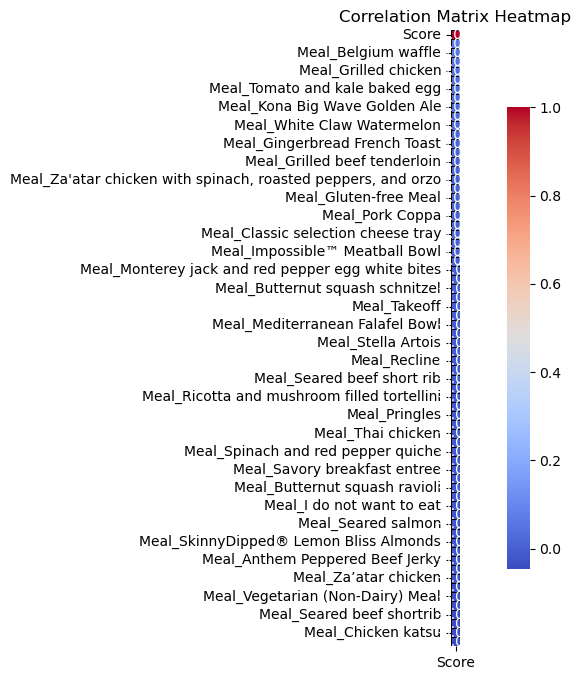

In [27]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_with_score, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=.5, linecolor='black', square=True,
            cbar_kws={"shrink": .75})
plt.title('Correlation Matrix Heatmap')
plt.show()

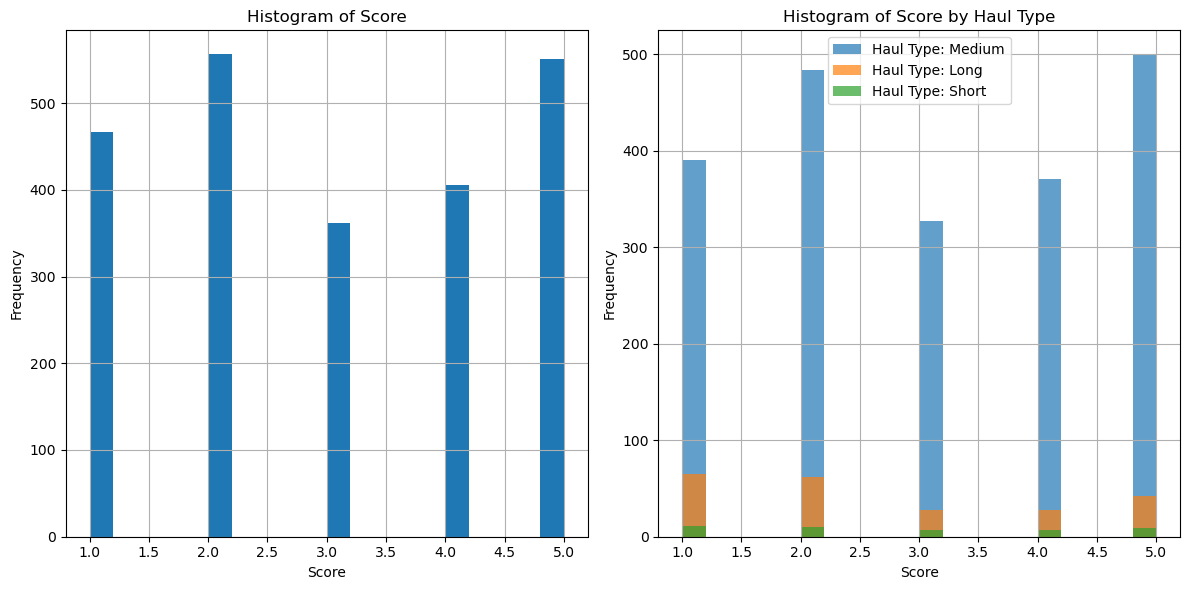

,Score
Score,1.000000
Haul_Type_Medium,0.081355
Haul_Type_Short,-0.015741
Haul_Type_Long,-0.080773


In [20]:
#drawing correlation with haul type
import matplotlib.pyplot as plt

# For demonstration purposes, we'll take a smaller subset of the data to avoid computational issues.
subset_data = final_merged_data.sample(frac=0.01, random_state=0)[['haul_type', 'score']].dropna()

# Perform one-hot encoding on the 'haul_type' column
one_hot_encoded_data = pd.get_dummies(subset_data['haul_type'], prefix='Haul_Type')

# Add the numerical 'score' column to the one-hot encoded DataFrame
one_hot_encoded_data['Score'] = subset_data['score']

# Compute the correlation matrix
correlation_matrix = one_hot_encoded_data.corr()

# Show the correlation between one-hot encoded haul types and the score
correlation_with_score = correlation_matrix.loc[:, ['Score']].sort_values(by='Score', ascending=False)

# Plotting histogram for score grouped by haul_type
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Histogram of Score')
subset_data['score'].hist(bins=20)
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.title('Histogram of Score by Haul Type')
for haul_type in subset_data['haul_type'].unique():
    subset_data[subset_data['haul_type'] == haul_type]['score'].hist(label=f'Haul Type: {haul_type}', alpha=0.7, bins=20)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

correlation_with_score


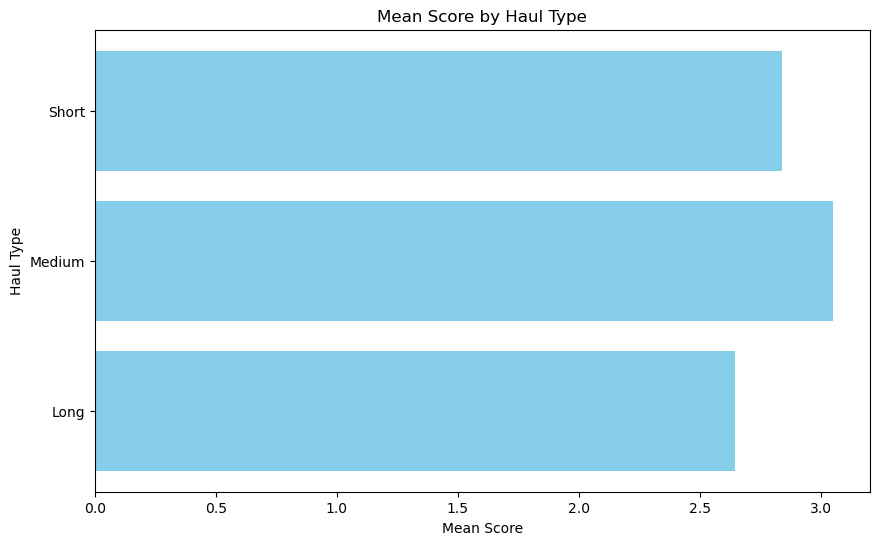

In [21]:
# Group data by 'haul_type' and calculate the mean score
grouped_data = subset_data.groupby('haul_type')['score'].mean()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(grouped_data.index, grouped_data.values, color='skyblue')

plt.xlabel('Mean Score')
plt.ylabel('Haul Type')
plt.title('Mean Score by Haul Type')
plt.show()


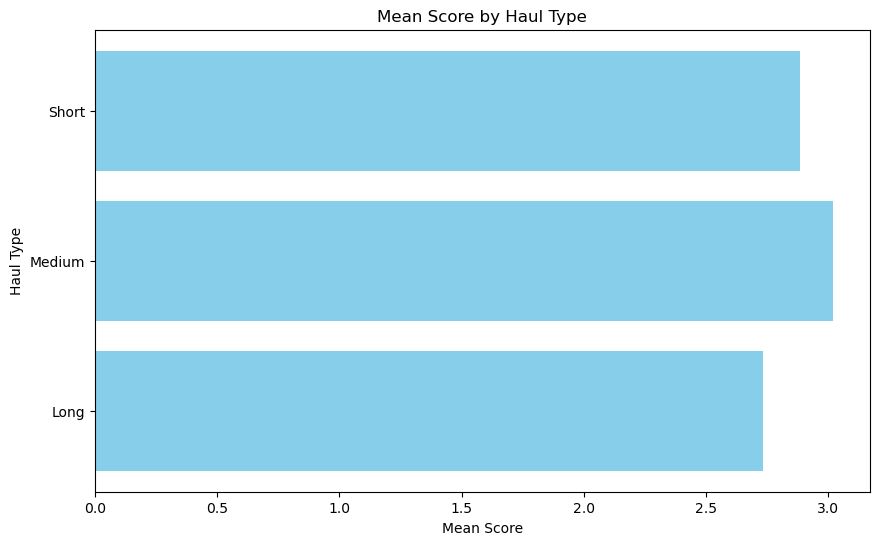

In [23]:
grouped_data = final_merged_data.groupby('haul_type')['score'].mean()

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(grouped_data.index, grouped_data.values, color='skyblue')

plt.xlabel('Mean Score')
plt.ylabel('Haul Type')
plt.title('Mean Score by Haul Type')
plt.show()


It may be seen that in 'medium haul' the average F&B satisfaction score is highest and lowest in long haul flights, thereby drawing actionable insight to work in improving F&B quality in short & long hauls.

In [34]:
#looking for any variability over entity wrt satisfaction score
full_data = pd.read_csv(ds1)

# Get unique values for 'entity' and 'score'
unique_entities = full_data['entity'].unique()
unique_scores = full_data['score'].unique()

unique_entities, unique_scores

(array(['Domestic', 'Pacific', 'Latin', 'Atlantic', nan], dtype=object),
 array(['2', '5', '3', '1', '4', 'chicken entrée', 'other (specify)',
        'vegetarian entrée', 'snack basket selection',
        'sandwich/burger/wrap', 'beef entrée', 'seafood entrée'],
       dtype=object))

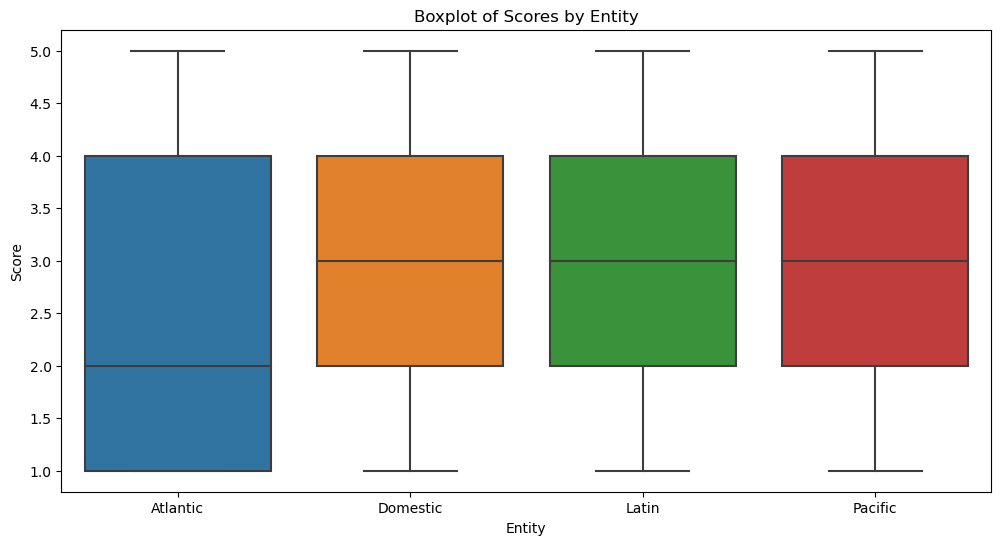

In [36]:
# Filter only rows with numerical 'score'
full_data['score'] = pd.to_numeric(full_data['score'], errors='coerce')
full_data = full_data.dropna(subset=['score'])

# Re-plot the correlation between 'score' and 'entity'
plt.figure(figsize=(12, 6))
sns.boxplot(x='entity', y='score', data=full_data, order=sorted(unique_entities[~pd.isna(unique_entities)]))
plt.title('Boxplot of Scores by Entity')
plt.xlabel('Entity')
plt.ylabel('Score')
plt.show()


A Widerr IQR (Inter-Quartile Range) in Atlantic suggests need to check consistency issues in Atlantic flights in order to improve overall F&B score

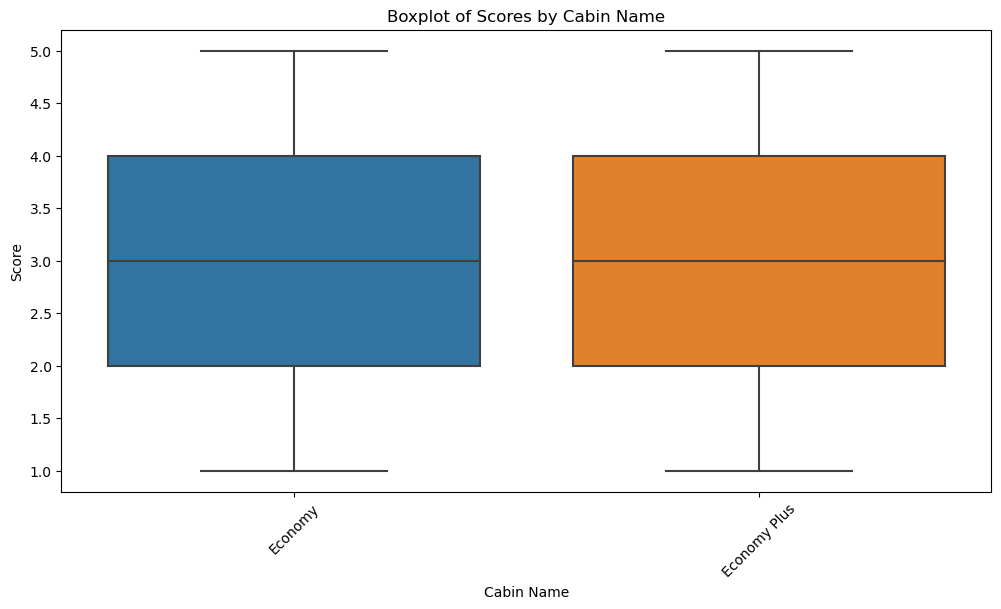

In [39]:
#IQR for Cabin types
# Get unique values for 'cabin_name' to use in the order parameter for the plot
unique_cabin_names = full_data['cabin_name'].dropna().unique()

# Plot the correlation between 'score' and 'cabin_name'
plt.figure(figsize=(12, 6))
sns.boxplot(x='cabin_name', y='score', data=full_data, order=sorted(unique_cabin_names))
plt.title('Boxplot of Scores by Cabin Name')
plt.xlabel('Cabin Name')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()


Distribution of F&B Satisfaction Rate is similar in both cabin types.

Drawing **Qualitative Insights** from customer comments

In [51]:
pip install wordcloud



     ------------------------------------ 153.3/153.3 kB 247.5 kB/s eta 0:00:00


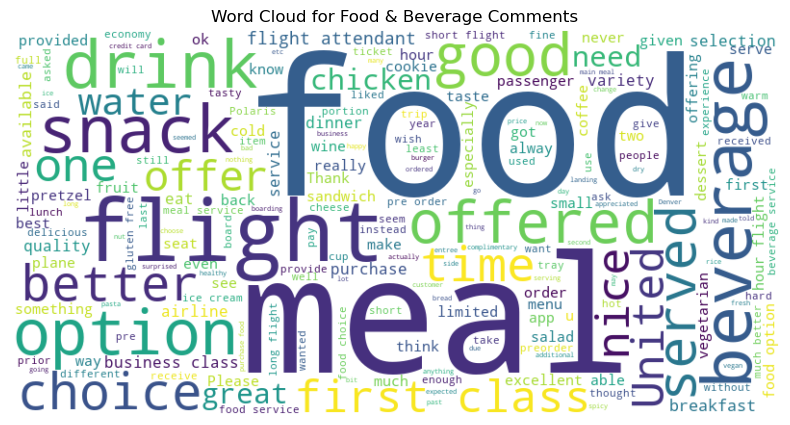

food         1585
flight        999
meal          849
good          358
did           343
class         333
beverage      333
offered       329
options       322
snack         296
better        280
meals         274
served        272
service       256
drink         252
like          249
beverages     224
snacks        221
just          218
time          212
dtype: int64

In [52]:
# Step 4: Qualitative Analysis

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 4.1 Text Mining
# Filter the dataset to include only rows with customer comments about F&B
food_comments = final_merged_data['verbatim_text'].dropna()
food_comments = food_comments[food_comments.str.contains('food|beverage|meal|drink', case=False, na=False)]

# Create a word cloud to identify major themes
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(food_comments))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Food & Beverage Comments")
plt.show()

vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(food_comments)

# Sum up the counts to get the frequency of each term
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
word_freq_sum = word_freq.sum().sort_values(ascending=False)

word_freq_sum


Based on the term frequency analysis of customer comments related to Food & Beverage (F&B), the following words appear most frequently:
food         1585 mentions

flight        999 mentions

meal          849 mentions

good          358 mentions

did           343 mentions

class         333 mentions

beverage      333 mentions

offered       329 mentions

options       322 mentions

snack         296 mentions

better        280 mentions

meals         274 mentions

served        272 mentions

service       256 mentions

drink         252 mentions

like          249 mentions

beverages     224 mentions

snacks        221 mentions

just          218 mentions

time          212 mentions


Major Themes:
Meal Options: The frequency of words like "meal," "options," "offered," and "available" suggests that the variety and availability of meals could be a concern for passengers.
Quality: Words like "good" and "better" could be indicative of passengers' expectations around the quality of food.
Pre-Ordering: The term "pre" is likely related to pre-ordering, suggesting that this is a notable topic among passengers.
Service: Words like "served," "class," and "united" may indicate that the level of service could also be a significant factor affecting F&B satisfaction.

CUSTOMER SEGMENTATION

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

# Step 1: Feature Selection
# Select relevant features for customer segmentation
segmentation_features = ['pre_order_qty', 'consumed_entree_count', 'arrival_delay_minutes', 'score']
segmentation_data = final_merged_data[segmentation_features].dropna()

# Step 2: Data Preprocessing
# Standardize the features to have mean=0 and variance=1
scaler = StandardScaler()
segmentation_data_scaled = scaler.fit_transform(segmentation_data)

# Convert scaled data back to a DataFrame
segmentation_data_scaled = pd.DataFrame(segmentation_data_scaled, columns=segmentation_features)

# Show the first few rows of scaled data for inspection
segmentation_data_scaled.head()


,pre_order_qty,consumed_entree_count,arrival_delay_minutes,score
0,-0.257560,0.807366,-0.907128,-0.716399
1,-0.257560,0.807366,-0.907128,-0.716399
2,0.938512,0.807366,-0.907128,-0.716399
3,-0.257560,0.807366,-0.907128,-0.716399
4,-0.257560,0.807366,-0.907128,-0.716399


In [54]:
# Set the number of clusters to 3 as a default value
num_clusters = 3

# Fit the K-Means algorithm to the data
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
segmentation_data_scaled['Cluster'] = kmeans.fit_predict(segmentation_data_scaled)

# Step 4: Profile Analysis
# Summarize the characteristics of each customer segment
cluster_profiles = segmentation_data_scaled.groupby('Cluster').mean()

# Add the size of each cluster to the profiles
cluster_profiles['Cluster_Size'] = segmentation_data_scaled['Cluster'].value_counts()

cluster_profiles


,pre_order_qty,consumed_entree_count,arrival_delay_minutes,score,Cluster_Size
Cluster,,,,,
0,-0.000069,-0.285298,-0.085544,1.079217,59815
1,0.000560,-0.403155,0.055362,-0.744274,79539
2,-0.001411,1.717589,0.024940,-0.187190,28605
